# BMI 203- Implementation of Auto-Encoder + Classifier
## Sanjay Rangavajjhala

# MNIST Digit Autoencoder

In [1]:
# Imports
import os
import sys
from nn.nn import NeuralNetwork
from nn.preprocess import sample_seqs, one_hot_encode_seqs
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nn.io import read_text_file, read_fasta_file


## load digits through sklearn

In [2]:
mnist_digits = datasets.load_digits()

## Split data into training and validation sets

In [3]:
#Split mnist data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(mnist_digits.data, mnist_digits.target, test_size=0.2, random_state=42)

## Generate an instance of my NeuralNetwork with 64x16x64 architecture

In [4]:
#Create architecture for 64x16x64 autoencoder
autoencoder_arch = [
    {"input_dim": 64, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 64, "activation": "relu"},
]
nn = NeuralNetwork(autoencoder_arch, lr=0.003, seed=42, batch_size=32, epochs=300, loss_function="mean_squared_error")

## Train autoencoder

In [5]:
train_loss, val_loss = nn.fit(X_train, X_train, X_val, X_val)

## Plot training/validation loss by epoch

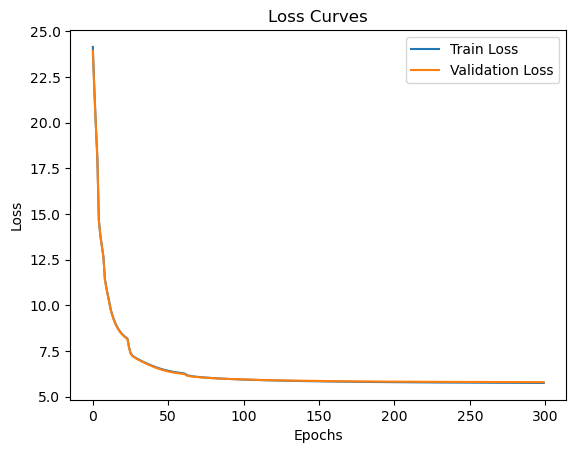

In [6]:
#Plot loss curves
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Quantify average reconstruction error over validation set

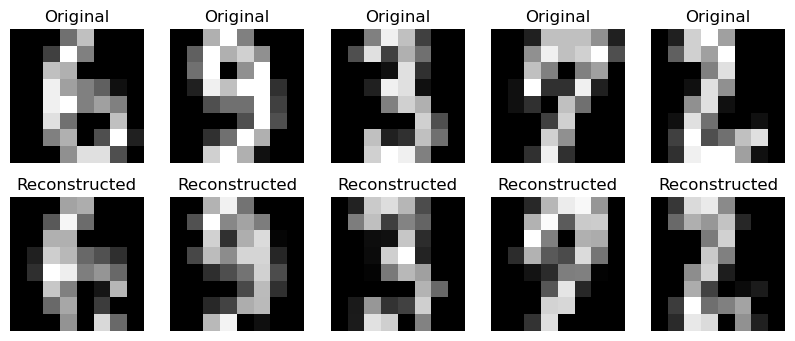

In [7]:
reconstruction = nn.predict(X_val.T).T

#View the original and reconstructed images
n = 5
plt.figure(figsize=(10, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_val[i].reshape(8, 8), cmap="gray")
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstruction[i].reshape(8, 8), cmap="gray")
    plt.title("Reconstructed")
    plt.axis("off")

In [8]:
ave_val_error = np.mean(np.square(X_val - reconstruction))
print(f"Average Validation Error: {ave_val_error}")

Average Validation Error: 5.796973840941358


## Explain choice of hyperparameters

When choosing hyperparameters, the most important one in the quality of my model was the learning rate. I began at lr=0.01 and saw that the losses seemed to bounce heavily between ~5 and ~14, which indicated that the lr was too big. I shifted it down to 0.005 where it was still jittery but notably got better performance than smaller lrs. Batch size, when varied between 8, 16, and 32, did not seem to have an effect on loss so I left it at 16. Finally, I set the number of epochs to 300 because by that point the loss curves showed that there was little to no further improvement in either the train or validation set. I use mse as my lsos because this was not a classification model, and relu as my activations seemed to show better results than binary cross entropy.

# Part 2: Classifying transcription factors

## Read in pos and negative examples

In [9]:
pos_examples = read_text_file('data/rap1-lieb-positives.txt')
neg_examples = read_fasta_file('data/yeast-upstream-1k-negative.fa')

#clip all neg examples to be length 17
neg_examples = [seq[:len(pos_examples[0])] for seq in neg_examples]

## Balance classes

I chose to sample with replacement until the positive and negative classes had the same number of sequences. This may result in repeats in ithe positive class, but I did this to ensure that there was no class imbalance as prior to this balancing there were far more negative than positive samples.

In [10]:
seq_data = pd.concat([pd.DataFrame({'sequence': pos_examples, 'label': True}), 
                      pd.DataFrame({'sequence': neg_examples, 'label': False})])
#Combine these 2 dfs together
seq_data = pd.concat([pd.DataFrame({'sequence': pos_examples, 'label': True}), pd.DataFrame({'sequence': neg_examples, 'label': False})])

X, y = sample_seqs(seq_data['sequence'], seq_data['label'])

## One hot encode Features

In [11]:
X_ohe = one_hot_encode_seqs(X)
y = np.array(y)

## Split into training and validation

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_ohe, y, test_size=0.2, random_state=42)

## Instantiate NN

In [13]:
len(X_val)

1266

In [34]:
nn_arch = [
    {"input_dim": 68, "output_dim": 30, "activation": "relu"},
    {"input_dim": 30, "output_dim": 10, "activation": "relu"},
    {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"}
]
nn_classifier = NeuralNetwork(nn_arch, lr=0.005, seed=42, batch_size=16, epochs=300, loss_function="binary_cross_entropy")

In [35]:
train_loss, test_loss = nn_classifier.fit(X_train, y_train, X_val, y_val)

# Plot Loss

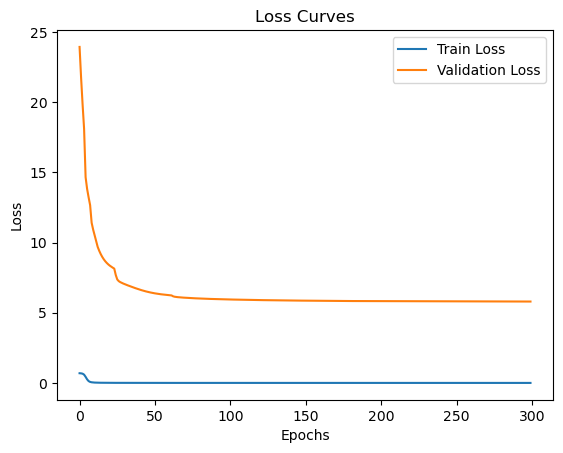

In [36]:
#Plot loss curves
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Report Accuracy

In [33]:
y_hat = nn_classifier.predict(X_val.T).T
accuracy = np.mean((y_hat > 0.5).flatten() == y_val)
print(f"Accuracy: {accuracy}")

Accuracy: 0.995260663507109


# Explain Choice of Hyperparameters

Truth be told, I am unsure why my loss curve looks like that. It is clear that training had an effect at reducing validation loss, to a point where it reached near perfect. However, it is unclear why train loss is initialized so low and remains there for the duration of training. I chose hyperparameters based on what worked for the MNIST autoencoder. When I tried increasing lr, I saw little change in performance (remained at ~0.99 accuracy). It is also very late, and so I figured that these hyperparameters shall work since the performance justifies it.